In [185]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf

import pystan

In [201]:
def month_string_to_number(string):
    """ month_string_to_number takes a month and turns it into the 
    corresponding number
    args:
        :string - each item is a string

    returns:
        :(out) - the equivalent of the month's number
    """
    m = {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr':4,
         'may':5,
         'jun':6,
         'jul':7,
         'aug':8,
         'sep':9,
         'oct':10,
         'nov':11,
         'dec':12
        }
    s = string.strip()[:3].lower()

    try:
        out = m[s]
        return out
    except:
        raise ValueError('Not a month')
        
path = '/Users/afugere/Desktop/UVM Masters/GraduateSemester2/STAT330/FinalProject/'
path2 = '/Users/abigailhotaling/Documents/STAT_330_Project/Data/'
figpath = '/Users/abigailhotaling/Documents/STAT_330_Project/Figures/'
data = pd.read_csv(path2+ 'Electricity_Residential_Price_New_England.csv')

#data.columns = ['Date', 'Electricity Residential Price: New England cents per kilowatthour']
data.columns = ['Date', 'Electricity Price']
# I also changed the column name for now, just to be a little bit shorter 
dates = []
months = []
years = []
for entry in data['Date']:
    dates.append(entry.replace('-', ' '))
    data['Month and Year'] = pd.Series(dates)
    months.append(month_string_to_number(str(entry[0:-3])))
    years.append(entry[-2:])
    data['Month'] = pd.Series(months)
    data['Year'] = pd.Series(years)
    
updated_years = []
for y in data['Year']:
    if int(y) > 19:
        updated_years.append('19'+y)
    else:
        updated_years.append('20'+y)
    data['Year'] = pd.Series(updated_years)
    
data['Day'] = [1]*len(data)

data['Datetime'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data.iloc[:] = data.iloc[::-1].values

In [3]:
# Seperate the forcasts from US EIA SHORT-TERM ENERGY OUTLOOK 
forcast_eia = data.iloc[-24:]

observed_data = data.iloc[:-24]

In [206]:
def plot_trace(param, param_name='parameter', save = False, path='parameter.png'):
    """Plot the trace and posterior of a parameter."""

    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    fig = plt.figure(figsize= (10, 7))
    ax1 = fig.add_subplot(2,1,1)
    
    #plt.subplot(2,1,1)
    ax1.plot(param)
    ax1.set_xlabel('samples')
    ax1.set_ylabel(param_name)
    ax1.axhline(mean, color='r', lw=2, linestyle='--')
    ax1.axhline(median, color='c', lw=2, linestyle='--')
    ax1.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    ax1.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    ax1.set_title('Trace and Posterior Distribution for {}'.format(param_name))

    ax2 = fig.add_subplot(2,1,2)
    ax2.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    ax2.set_xlabel(param_name)
    ax2.set_ylabel('density')
    ax2.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    ax2.axvline(median, color='c', lw=2, linestyle='--',label='median')
    ax2.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
    ax2.axvline(cred_max, linestyle=':', color='k', alpha=0.2)

    #ax2.gcf().tight_layout()
    ax2.legend(loc='best')
    
    if save:
        fig.savefig(path)
    

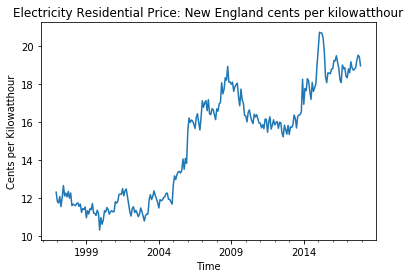

In [5]:
ax = observed_data.plot(x = 'Datetime', y = 'Electricity Price', 
               title = 'Electricity Residential Price: New England cents per kilowatthour', legend = False)
ax.set_xlabel('Time')
ax.set_ylabel('Cents per Kilowatthour')
ax.format_xdata = mdates.DateFormatter('%Y-%m')

In [220]:
def prediction_plots(dates, data, prediction, forecast_length, xlim = None, ylab = 'Electricity Price', differenced = False):
    """
    Function to plot observed data and predicted/forecasted data
    
    Parameters
    ----------
    dates : list 
        List of dates for entire time (including forecast dates)
    
    data : list of float 
        List of observed electricity prices 
        
    P : int
        The number of lags in the model 
        
    forecast : list
        List with the first element being the 2.5 and 97.5 percentiles of the forecast
        and the second element is the mean of the posterior forecast 
        
    xlim : list, optional
        list of lower and upper limit (default = None), 
        if you want the max xlim or min xlim use 'xmin' or 'xmax' in the list
        
    ylab : str, optional 
        String of ylabel (default = 'Electricty Price')
    """
    
    fig, ax = plt.subplots(figsize = (10, 7))
    #pred = list(prediction.reshape((len(prediction),)))
    pred_forecast = prediction[1]
    lower = np.array(list(prediction[1][:-forecast_length]) + list(prediction[0][0][-forecast_length:])).reshape(len(prediction[0][0]),)
    upper = np.array(list(prediction[1][:-forecast_length]) + list(prediction[0][1][-forecast_length:])).reshape(len(prediction[0][0]),)
    
    ax.fill_between(list(range(len(lower))), np.array(lower), np.array(upper), color = 'blue', alpha = 0.2)
    if differenced:
        ax.plot(data, label = 'Observed Prices', color = 'black', alpha = 0.8)
        ax.plot(pred_forecast, label = 'Predicted', color = 'blue', alpha=0.8, linestyle = '--')

    else:
        ax.plot(dates, data, label = 'Observed Prices', color = 'black', alpha = 0.8)
        ax.plot(dates, pred_forecast, label = 'Predicted', color = 'blue', alpha=0.8, linestyle = '--')

    
    ax.legend(loc='best', fontsize=14)
    
    ax.set_xlabel('Months', fontsize = 13)
    ax.set_ylabel(ylab)

    #ax.format_xdata = mdates.DateFormatter('%Y-%m')
    
    xmin, xmax = ax.get_xlim()
    limit_dict = {'xmin':xmin, 'xmax':xmax}
    xlim_transformed = [0,0]
    if xlim:
        if xlim[0] == 'xmin':
            xlim_transformed[0] = xmin
        else:
            xlim_transformed[0] = xlim[0]
        if xlim[1] == 'xmax':
            xlim_transformed[1] = xmax
            
        else:
            xlim_transformed[1] = xlim[1]
            
        ax.set_xlim((xlim_transformed[0], xlim_transformed[1]))
        
def residuals(data, prediction):
    residuals = [d-p for d,p in zip(data, prediction)]
    return residuals 

## Forecasts
Here is a good link about ARIMA forecasts 


http://www-stat.wharton.upenn.edu/~stine/insr260_2009/lectures/arma_forc.pdf

I thought I had the code working right but I don't think I do yet 


### ARIMA model

P = number of lags for auto regressive

Q = number of lags for moving average

$y_t = \mu + \phi_1 y_{t-1} + ... +\phi_p y_{t-p}+ w_t +\theta_1 w_{t-1}+...+\theta_q w_{t-q} + \epsilon_t$
[Not sure about notation. It's hard to keep everything straight all of the sources seem to have different notation]

$w_t$ is the moving average

If fitting a model with differencing of 1:

$z_t = y_t - y_{t-1}$

$z_t = \mu + \phi_1 z_{t-1} + ... +\phi_p z_{t-p}+ w_t +\theta_1 w_{t-1}+...+\theta_q w_{t-q}+ \epsilon_t$

$\epsilon_t \sim N(0, \sigma^2)$

Need to estimate posterior for $\sigma^2$, $\phi_p$, $\theta_q$, $\mu$ for $p=1, ...,P$ and $q=1,...,Q$ 

Priors: 

$\mu \sim N(0, 1)$

$\phi_p \sim N(0, 1)$ for i in $p=1, ...,P$

$\theta_q \sim N(0, 1)$ for i in $q=1, ...,Q$

$\sigma^2 \sim \Gamma^{-1}(a, b)$



In [212]:
# ARIMA Model 2 
# https://github.com/jeffalstott/pystan_time_series/blob/master/stan_models/ARIMA.stan
stan_code_m22 = """
data {

    int T; // number of time steps
    int K; // Number of time series
    int T_new; // number of time steps to forecast
    int<lower=0,upper=T-1> P; // Number of lags for AR element
    int<lower=0,upper=T-1> Q; // Number of lags for MA element

    matrix[T, K] Y; // data to model

    // priors
    real mu_prior_location;
    real mu_prior_scale;

    real sigma_prior_location;
    real sigma_prior_scale;

    vector[P] phi_prior_location;
    vector[P] phi_prior_scale;

    real theta_prior_location;
    real theta_prior_scale;
}

transformed data {
    matrix[T,P] Y_lagged[K];
    
    for (k in 1:K){
        Y_lagged[k] = rep_matrix(0,T,P);
        for (p in 1:P){
            Y_lagged[k, p+1:T,p] = Y[1:T-p,k];
        }
    } 
}

parameters {
    vector[K] mu;
    vector<lower=0>[K] sigma;
    matrix[K,P] phi;
    matrix<lower=-1, upper=1>[K,Q] theta;
    
}

model {
    matrix[T,K] err;
    matrix[T,K] nu;
    
    mu ~ normal(mu_prior_location, mu_prior_scale);
    //sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    sigma ~ inv_gamma(sigma_prior_location, sigma_prior_scale);

    for (p in 1:P){
        phi[:,p] ~ normal(phi_prior_location[p], phi_prior_scale[p]);
    }
    for (q in 1:Q){
        theta[:,q] ~ normal(theta_prior_location, theta_prior_scale);
    }

    for (k in 1:K) {
        nu[:,k] = rep_vector(mu[k], T);

        if (P>0){
            nu[:,k] = nu[:,k] + Y_lagged[k]*phi[k]';
            }

        err[:,k] = Y[:,k] - nu[:,k];

        if (Q>0){
            if (Q>1){
                for (t in 2:Q){
                    nu[t,k] = nu[t,k] + theta[k,1:t-1]*err[1:t-1, k];
                    err[t,k] = Y[t,k] - nu[t,k];
                }
            }
            for (t in 1+Q:T){
                nu[t,k] = nu[t,k] + theta[k]*err[t-Q:t-1,k];
                err[t,k] = Y[t,k] - nu[t,k];
                }
        }

        err[1+max(P,Q):,k] ~ normal(0, sigma[k]);
    }
}
generated quantities{
    matrix[T+T_new, K] y_pred;
    matrix[T+T_new,K] err;
    matrix[T+T_new, P] y_pred_lagged;
    matrix[T+T_new,K] nu;

    for (k in 1:K){
        err[:,k] = rep_vector(0, T+T_new);
        y_pred_lagged[1:T] = Y_lagged[k,1:T];
        for (t in 1:(T+T_new)){
            if (t<=T){ //Predict
                //nu[t,k] = mu[k];
                nu[t,k] = mu[k] + Y_lagged[k, t]*phi[k]';
                err[t,k] = Y[t,k]-nu[t,k];
                
            }
            if (t>T){//Forecast
                for (p in 1:P){
                    y_pred_lagged[t,p] = y_pred[t-p,k];
                }
                nu[t,k] = mu[k] + y_pred_lagged[t]*phi[k]';
                

            }
            
            if (Q>0){
                    if (t>Q){
                        nu[t,k] = nu[t,k] + theta[k]*err[t-Q:t-1, k];
                    }
                    if (t<Q){
                        if (t>1){
                            nu[t,k] = nu[t,k] + theta[k, 1:t-1]*err[1:t-1, k];
                        }
                    }
            }
            y_pred[t, k] = normal_rng(nu[t,k], sigma[k]);
            
      }        
    }
} 
"""

#### Split data into training and testing sets
Use 2015 - 2017 as the test

In [215]:
y = list(observed_data['Electricity Price'])
n = len(y)
forecast_length = 12
train = observed_data[:-forecast_length]
test = observed_data[-forecast_length:]
train_y = list(train['Electricity Price'])
z_1 = [y[i] - y[i-1] for i in range(1,len(y))] # data with differencing of 1 lag
z_1_train = z_1[:-forecast_length]
z_1_test = z_1[-forecast_length:]
dates = list(observed_data.Datetime.map(lambda x: x.strftime('%Y-%m')))
P = 5
Q =2

In [217]:
m2_data = {'T':len(z_1_train), 'K':1, 'P':P, 'Q':Q, 'Y':np.asarray(z_1_train).reshape(len(z_1_train), 1),
           "mu_prior_location": 0, 'mu_prior_scale':100, 'sigma_prior_location': .1, 'sigma_prior_scale':1, 
           'phi_prior_location':[0]*P, 'phi_prior_scale':[100]*P, 'theta_prior_location':0, 'theta_prior_scale':100, 'T_new': 12}


In [218]:
iterations = 2000
warmup = 1000
fit = pystan.stan(model_code=stan_code_m22, data=m2_data,
                  iter=iterations, warmup = warmup, chains=3)



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_366c6c6a033f169b1355f2d89d5f625b NOW.


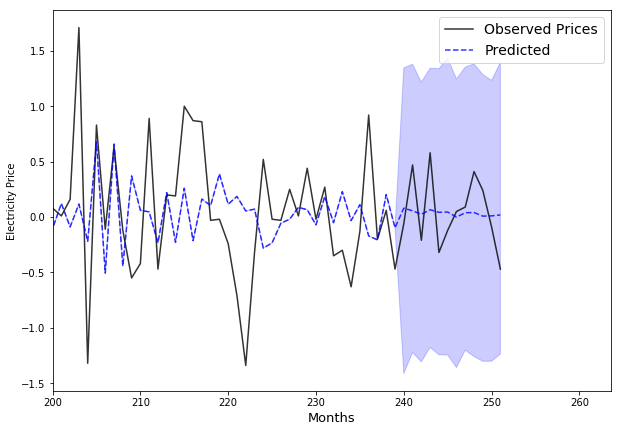

In [222]:
prediction = [np.percentile(fit.extract(permuted=True)['y_pred'], q=[2.5, 97.5], axis=0), np.mean(fit.extract(permuted=True)['y_pred'], axis = 0)]
prediction_plots(dates, z_1, prediction, 12, xlim = [200, 'xmax'], differenced = True)


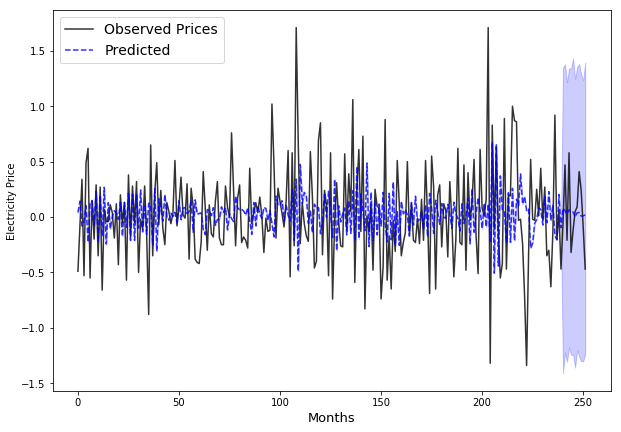

In [237]:
prediction_plots(dates, z_1, prediction, 12, xlim = None, differenced = True)


#### Check for convergance 

In [223]:
summary_dic = fit.summary()
summary_dic

df = pd.DataFrame(summary_dic['summary'], columns = summary_dic['summary_colnames'], index=summary_dic['summary_rownames'])

In [224]:
df_model_params = df.iloc[:2+P+Q]
param_names = list(df_model_params.index)


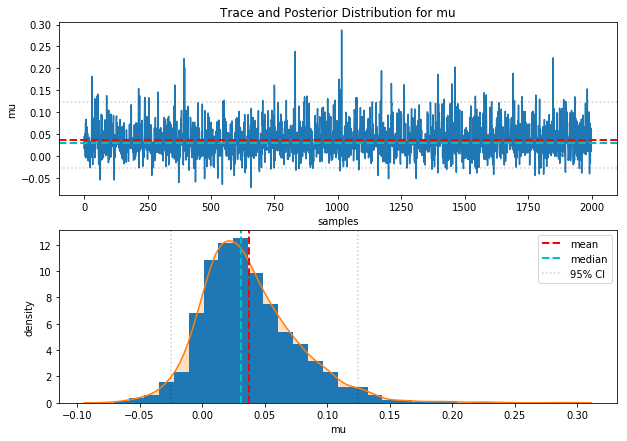

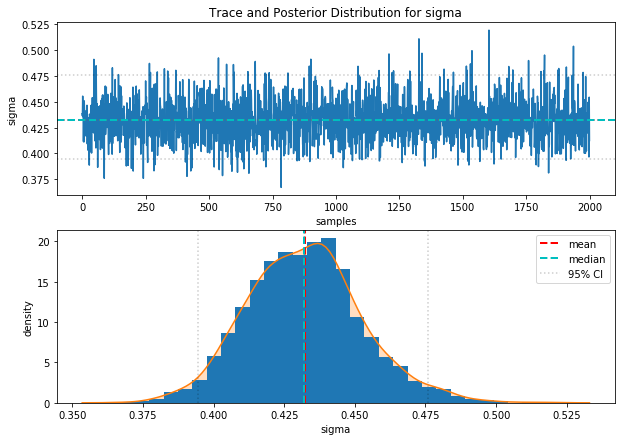

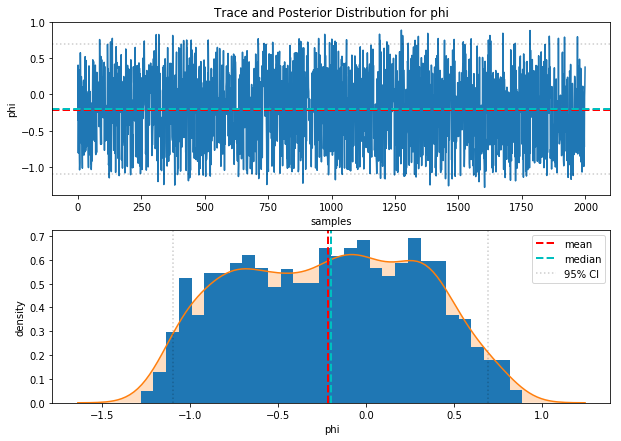

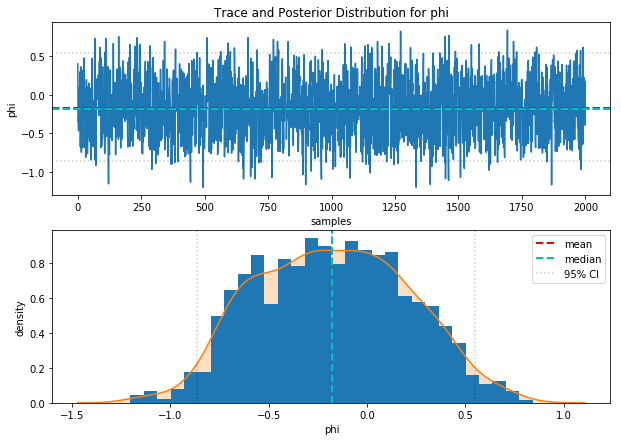

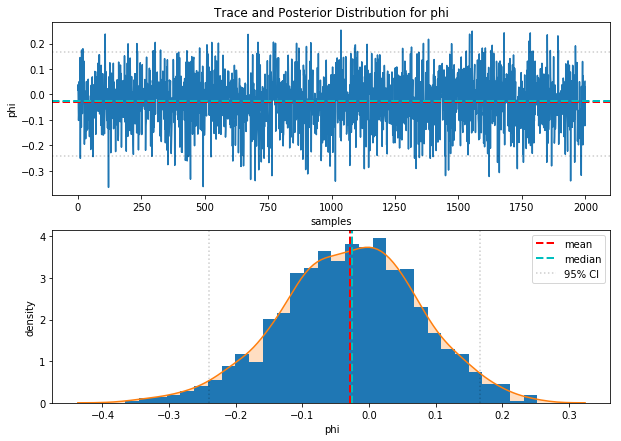

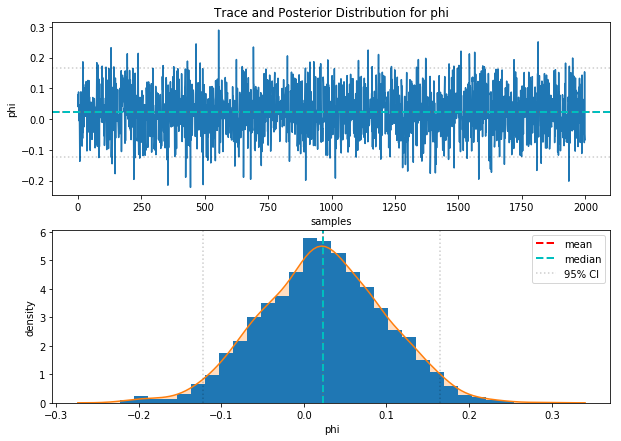

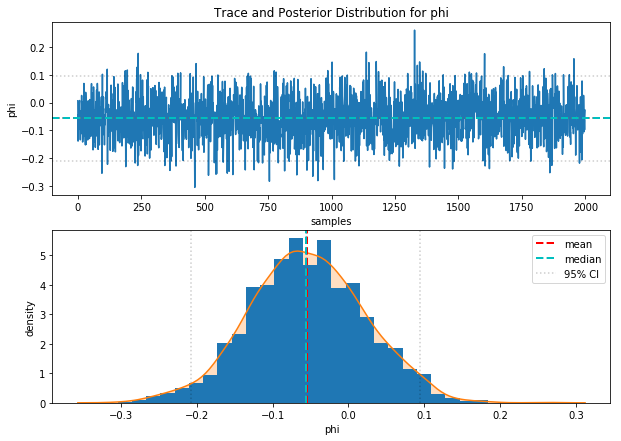

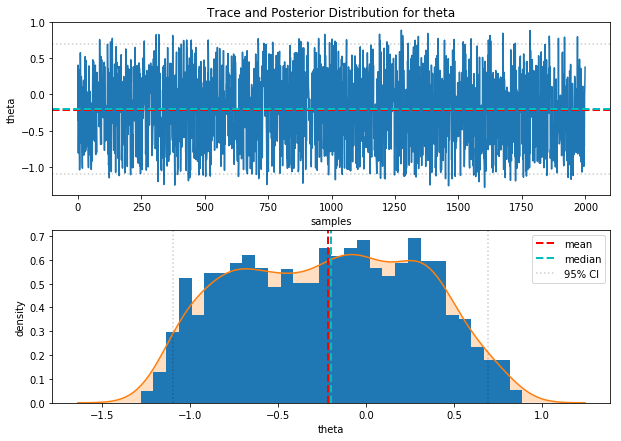

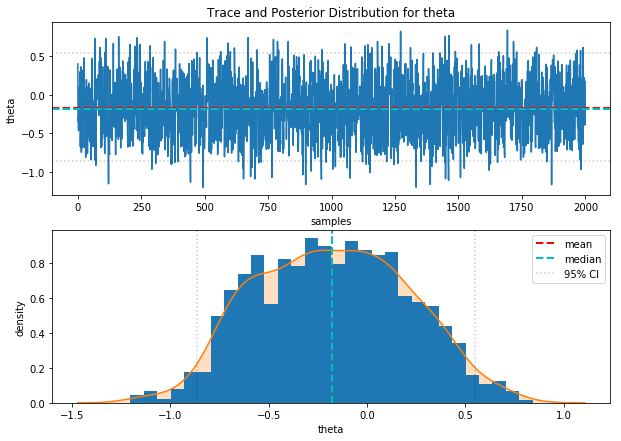

In [225]:
save = False # need to be able to save these plots 
for param in param_names:
    # strip the indexes of the parameter name 
    param_split = param.split('[')
    name = param_split[0]
    if name == 'mu' or name =='sigma':
        path = figpath + name+'_' +'_trace_plot.png'
        plot_trace(fit[name][warmup:warmup+iterations], name, save=True, path = path)
    else:
        get_index = param_split[1].split(']')
        get_k_i = get_index[0].split(',')
        k = int(get_k_i[0])
        i = int(get_k_i[1])
        trace = [fit['phi'][j][k-1][i-1] for j in range(warmup,warmup+iterations)]
        path = figpath + name+'_' +get_index[0]+'_trace_plot.png'
        plot_trace(trace, name, save=True, path = path)
        
        
        

#### Check Residuals 

Text(0.5,1,'Residuals')

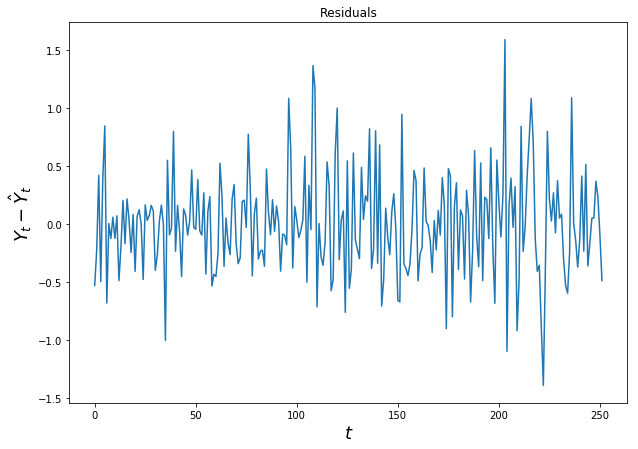

In [231]:
resid = residuals(z_1, prediction[1])
fig, ax = plt.subplots(figsize = (10, 7))
ax.plot(resid)
ax.set_ylabel(r'$Y_t - \hat{Y}_t$', fontsize = 18)
ax.set_xlabel(r'$t$', fontsize = 18)
#ax.set_ylim((-2,2))
ax.set_title('Residuals')

/Users/abigailhotaling/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


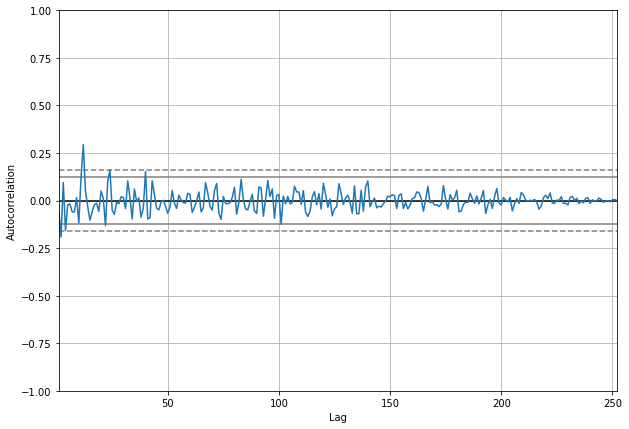

In [232]:
# residual autocorrelation
fig = plt.figure(figsize = (10,7))
autocorrelation_plot(resid)

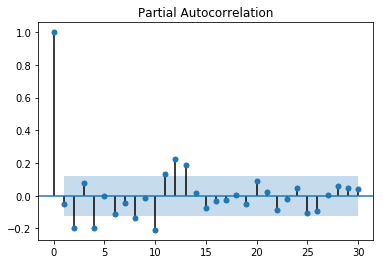

<Figure size 720x504 with 0 Axes>

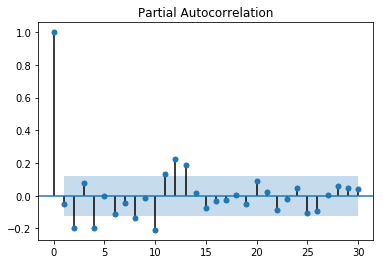

In [233]:
# residual partial autocorrelation
fig = plt.figure(figsize = (10,7))
plot_pacf(resid, lags=30)

/Users/abigailhotaling/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


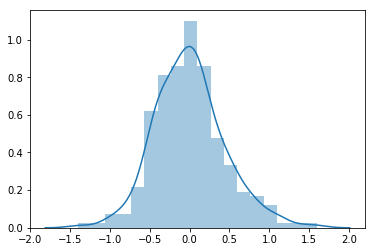

In [234]:
sns.distplot(resid)

In [236]:
# MSE 

mse = sum([r**2 for r in resid])/len(resid)
mse

array([0.19454035])

### Bayesian Structural Modeling 
http://people.ischool.berkeley.edu/~hal/Papers/2013/pred-present-with-bsts.pdf

https://multithreaded.stitchfix.com/blog/2016/04/21/forget-arima/

Generally, we can write a Bayesian structural model like this:

$$Y_t=\mu_t+x_t\beta+S_t+e_t,e_t\sim N(0,\sigma^2_e)$$
$$\mu_t+1=\mu_t+\nu_t,\nu_t∼N(0,\sigma^2_\nu)$$
Here $x_t$ denotes a set of regressors, $S_t$ represents seasonality, and $\mu_t$ is the local level term. The local level term defines how the latent state evolves over time and is often referred to as the unobserved trend. This could, for example, represent an underlying growth in the brand value of a company or external factors that are hard to pinpoint, but it can also soak up short term fluctuations that should be controlled for with explicit terms. Note that the regressor coefficients, seasonality and trend are estimated simultaneously, which helps avoid strange coefficient estimates due to spurious relationships (similar in spirit to Granger causality, see 1). In addition, due to the Bayesian nature of the model, we can shrink the elements of $\beta$ to promote sparsity or specify outside priors for the means in case we’re not able to get meaningful estimates from the historical data (more on this later).

In [ ]:
# I found this online havent done anything with it yet 
# https://discourse.mc-stan.org/t/bayesian-structural-time-series-modeling/2256/2

bsts = """
data {
  int <lower=0> T;
  vector[T] x;
  vector[T] y;
}

parameters {
  vector[T] u_err; //Slope innovation
  vector[T] v_err; //Level innovation
  real beta;
  real <lower=0> s_obs;
  real <lower=0> s_slope;
  real <lower=0> s_level;
}

transformed parameters {
  vector[T] u; //Level
  vector[T] v; //Slope
  u[1] = u_err[1];
  v[1] = v_err[1];
  for (t in 2:T) {
    u[t] = u[t-1] + v[t-1] + s_level * u_err[t];
    v[t] = v[t-1] + s_slope * v_err[t];
  }
}

model {
  u_err ~ normal(0,1);
  v_err ~ normal(0,1);
  y ~ normal (u + beta*x,s_obs);
}
"""